In [36]:
#Step 1 : Data Collection and understanding
import pandas as pd
df = pd.read_csv('online_retail.csv')

In [37]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [38]:
#Step 2 : Data Cleaning and Preprocessing

df.info()
print("shape:", df.shape)
print("Missing values:", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
shape: (541909, 8)
Missing values: InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Duplicate rows: 5268


In [39]:
#Step 2 : Data Preprocessing
df = df.drop_duplicates()
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
df = df[~df["CustomerID"].isnull()]
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]

In [40]:
print("shape after cleaning the data:", df.shape)

shape after cleaning the data: (392692, 9)


In [41]:
#Step 3 : Exploratory Data Analysis (EDA)

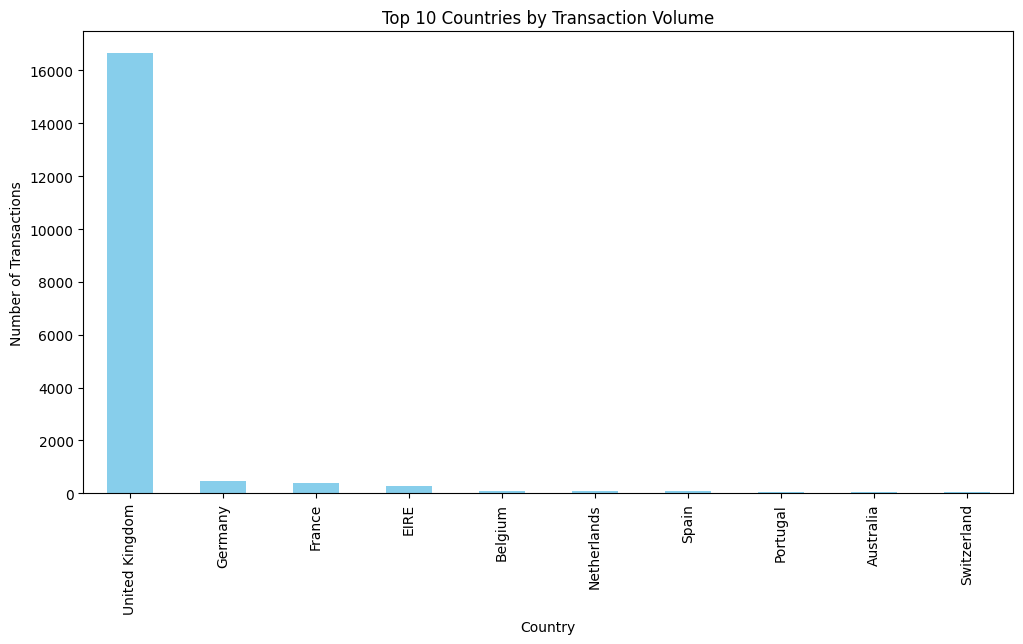

In [42]:
# Transaction volume by country
# Top 10 countries had the highest number of unique transactions (invoices)
import matplotlib.pyplot as plt
country_sales = df.groupby("Country")["InvoiceNo"].nunique().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
country_sales.plot(kind="bar", color="skyblue")
plt.title("Top 10 Countries by Transaction Volume")
plt.ylabel("Number of Transactions")
plt.show()

Text(0, 0.5, 'Total Quantity Sold')

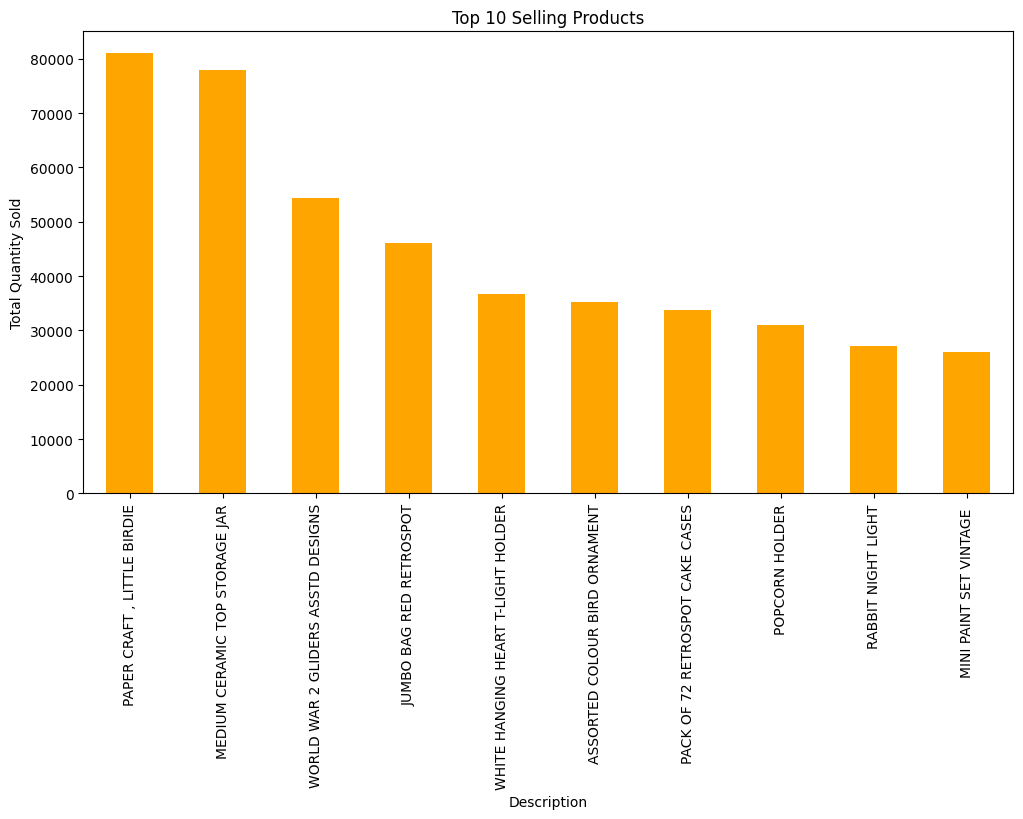

In [43]:
# top-selling products
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
top_products.plot(kind="bar", color="orange")
plt.title("Top 10 Selling Products")
plt.ylabel("Total Quantity Sold")

Text(0.5, 0, 'Month')

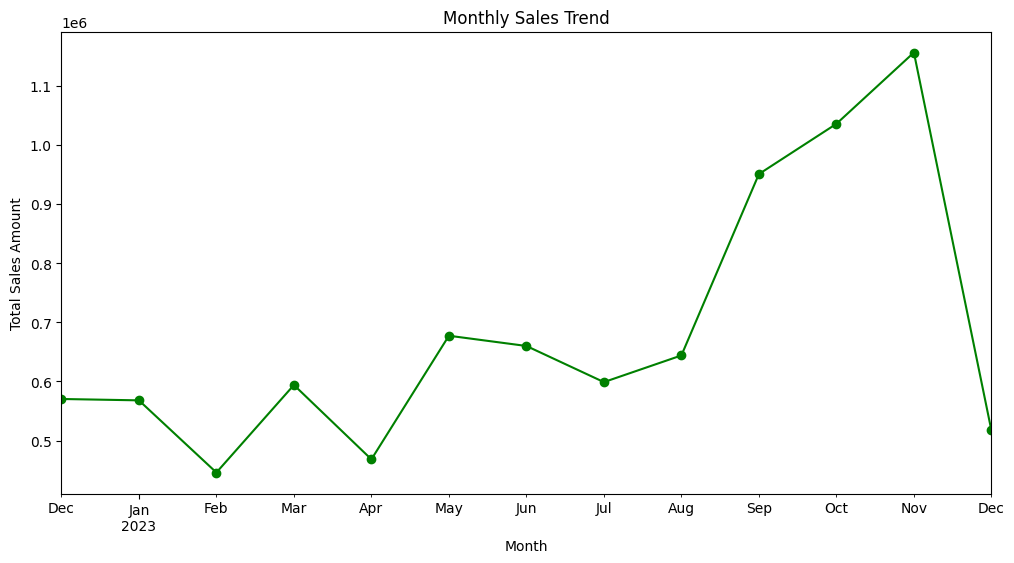

In [44]:
#purchase trends over time (Monthly sales Trend)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalAmount'].sum()
plt.figure(figsize=(12,6)) 
monthly_sales.plot(kind='line', marker='o', color='green')
plt.title('Monthly Sales Trend')
plt.ylabel('Total Sales Amount')
plt.xlabel('Month')

Text(0, 0.5, 'Frequency')

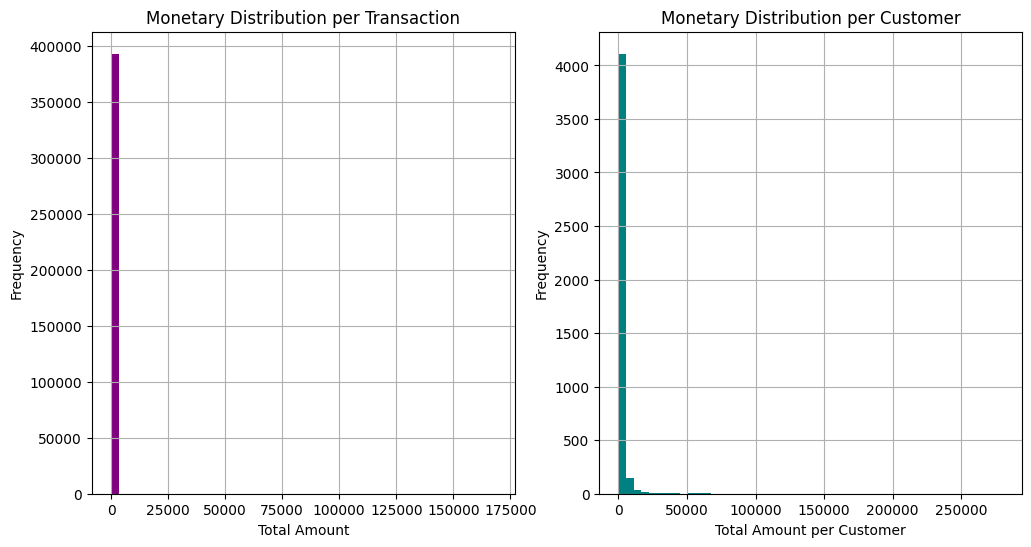

In [45]:
# Inspect monetary distribution per transaction and customer
# Almost all transactions are small amounts (clustered close to 0 on the x-axis).
# Very few transactions are very large (the line stretches out to ₹175,000, but those are rare).
# Every bar = total spending of one customer across all their shopping.
# Most customers spend small totals (close to 0–10,000).
# A few customers spend huge totals (up to ₹250,000+).
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)    
df['TotalAmount'].hist(bins=50, color='purple')
plt.title('Monetary Distribution per Transaction')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df.groupby('CustomerID')['TotalAmount'].sum().hist(bins=50, color='teal')
plt.title('Monetary Distribution per Customer')
plt.xlabel('Total Amount per Customer')
plt.ylabel('Frequency')


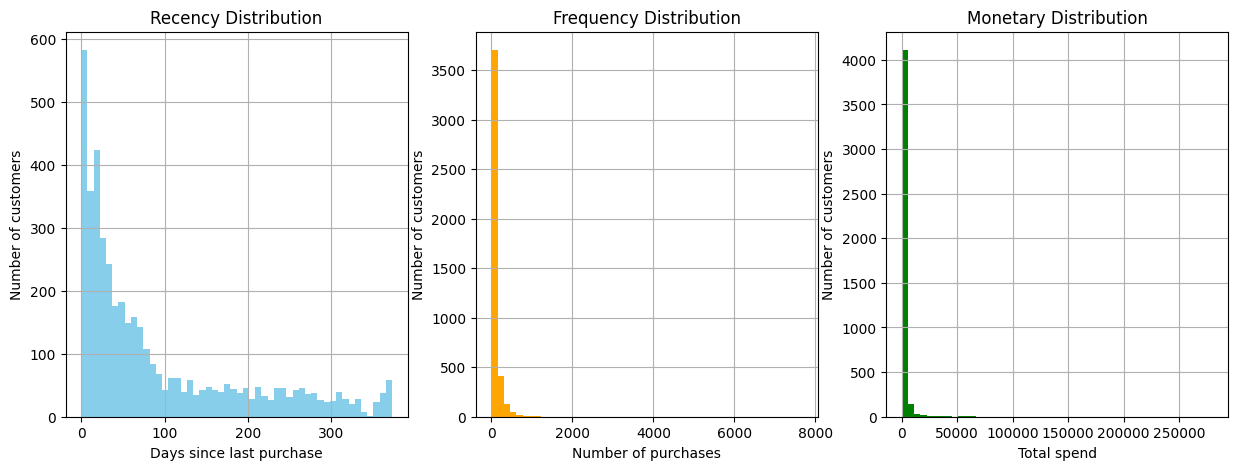

In [46]:
#RFM distributions
#Recency	How long since their last purchase	Most customers are recent buyers 👍
#Frequency	How often they bought	Most customers only bought once or twice 🤔
#Monetary	How much they spent in total	A few customers spent a lot 💸

#Recency Distribution (Days since last purchase)
#Most customers purchased recently — the data is right-skewed.
#As recency increases, the number of customers drops sharply.

#Heavily right-skewed — most customers purchased only a few times.
#A small number of very frequent buyers (likely loyal customers).

#Again, most customers spend small amounts.
#A few high spenders — potential VIPs.

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

ref_date = df['InvoiceDate'].max()
# Calculate RFM values
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                               # Frequency
    'TotalAmount': 'sum'                                # Monetary
}).reset_index()

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalAmount': 'Monetary'}, inplace=True)

plt.figure(figsize=(15,5))

# Recency
plt.subplot(1,3,1)
rfm['Recency'].hist(bins=50, color='skyblue')
plt.title('Recency Distribution')
plt.xlabel('Days since last purchase')
plt.ylabel('Number of customers')

# Frequency
plt.subplot(1,3,2)
rfm['Frequency'].hist(bins=50, color='orange')
plt.title('Frequency Distribution')
plt.xlabel('Number of purchases')
plt.ylabel('Number of customers')

# Monetary
plt.subplot(1,3,3)
rfm['Monetary'].hist(bins=50, color='green')
plt.title('Monetary Distribution')
plt.xlabel('Total spend')
plt.ylabel('Number of customers')

plt.show()


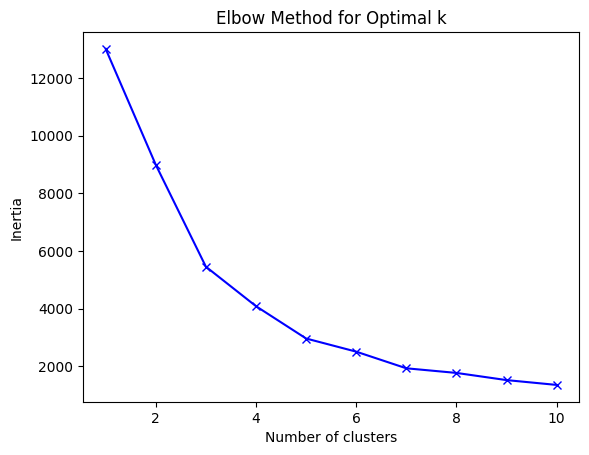

In [47]:
# Elbow curve for cluster selection
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
X = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
k = range (1, 11)
inertia = []
for i in range(1, 11):
 kMeans = KMeans(n_clusters=i, random_state=42)
 kMeans.fit(X_scaled)
 inertia.append(kMeans.inertia_)
inertia
plt.plot(k, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


k=2, silhouette score=0.9312
k=3, silhouette score=0.6040
k=4, silhouette score=0.6057
k=5, silhouette score=0.6166
k=6, silhouette score=0.5149
k=7, silhouette score=0.5270
k=8, silhouette score=0.5241
k=9, silhouette score=0.5071
k=10, silhouette score=0.4315


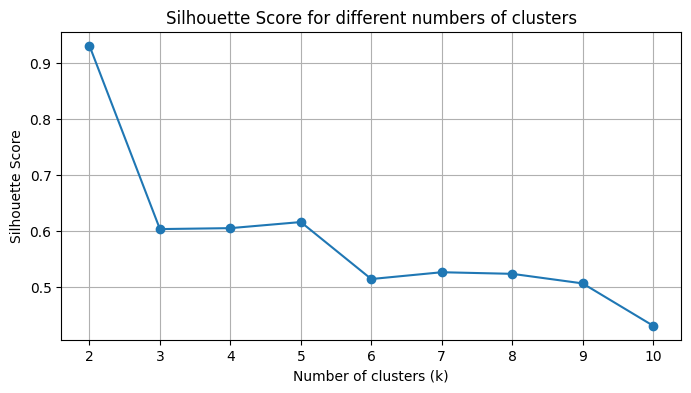

In [48]:
# Silhouette Score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette_scores = []

# Start from k=2, because k=1 is invalid for silhouette_score
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"k={k}, silhouette score={score:.4f}")

plt.figure(figsize=(8,4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for different numbers of clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale data (important for KMeans)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Fit KMeans (k=4 as you chose)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Profile clusters
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'}).reset_index()

print(cluster_profile)

# Corrected label mapping based on your cluster understanding
cluster_labels = {
    0: 'Regulars',
    1: 'High Value Customers',
    2: 'Occasional Customers',
    3: 'VIP Customers'  # You can rename or investigate this cluster
}

# Map readable labels
rfm['Customer_Label'] = rfm['Cluster'].map(cluster_labels)

# Profile clusters with labels
cluster_profile_labels = rfm.groupby('Customer_Label').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'}).reset_index()

print(cluster_profile_labels)


   Cluster     Recency    Frequency       Monetary  NumCustomers
0        0   40.443245   101.011104    1943.356013          3242
1        1   30.000000   915.857143  121183.096429            14
2        2  246.330241    27.386827     563.855622          1078
3        3    1.000000  5717.250000   70612.247500             4
      Customer_Label     Recency    Frequency       Monetary  NumCustomers
0    Active Regulars   40.443245   101.011104    1943.356013          3242
1  At-Risk Customers   30.000000   915.857143  121183.096429            14
2    Other Customers    1.000000  5717.250000   70612.247500             4
3  Top VIP Customers  246.330241    27.386827     563.855622          1078


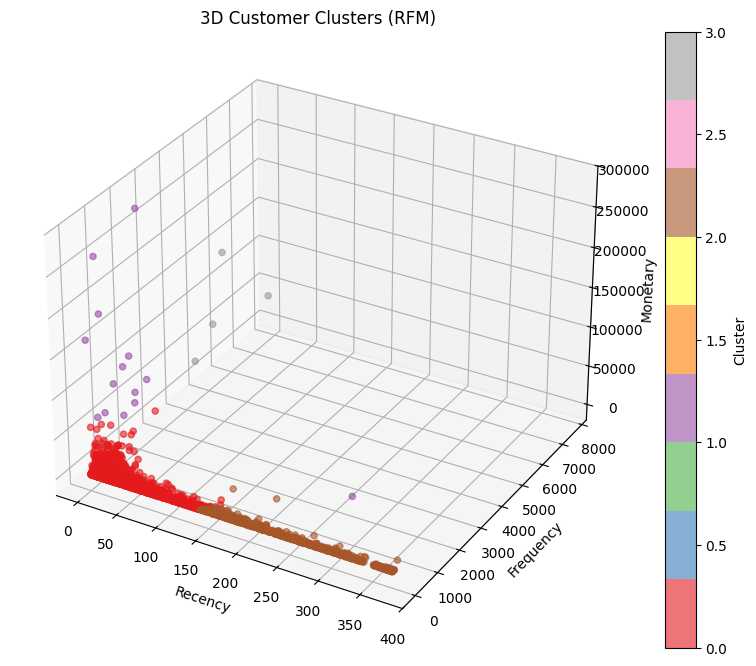

In [22]:
#3D Visualization of Clusters
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
                c=rfm['Cluster'], cmap='Set1', alpha=0.6)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Customer Clusters (RFM)')

plt.colorbar(sc, label='Cluster')
plt.show()


In [23]:
#Saving the Model

import joblib

joblib.dump(scaler, 'scaler.joblib')
joblib.dump(kmeans, 'kmeans_model.joblib')

['kmeans_model.joblib']

In [25]:
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Assuming your DataFrame is 'df' with columns: CustomerID, Description (product name)

# Step 1: Create Customer-Product matrix (pivot)
customer_product_matrix = df.pivot_table(index='CustomerID', columns='Description', 
                                         aggfunc='size', fill_value=0)

#print(customer_product_matrix.head())


# Step 2: Compute cosine similarity between products (columns)
# Transpose to have products as rows
product_similarity = cosine_similarity(customer_product_matrix.T)



# Convert similarity matrix to DataFrame for easier lookup
product_similarity_df = pd.DataFrame(product_similarity, 
                                     index=customer_product_matrix.columns, 
                                     columns=customer_product_matrix.columns)

# Function to get top 5 similar products for a given product
def get_similar_products(product_name, top_n=5):
    if product_name not in product_similarity_df.index:
        return f"Product '{product_name}' not found in the dataset."

    # Sort products by similarity score, descending, ignoring the product itself
    similar_scores = product_similarity_df[product_name].sort_values(ascending=False).drop(product_name)
    top_products = similar_scores.head(top_n).index.tolist()
    return top_products


product_similarity_df.to_pickle('product_similarity.pkl')




